![Fixel Algorithms](https://fixelalgorithms.co/images/CCExt.png)

# <center> Deep Learning Methods </center>
## <center> Lecture 5 - Deep Learning Basics</center>
### <center> Regularization Methods (Weight Decay and Dropout)</center>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/DeepLearningMethods/05_Regularizations/MainRegularization1.ipynb)

In [3]:
#-- Wide screen:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [4]:
#-- Auto reload:
%load_ext autoreload
%autoreload 2

In [5]:
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rc('font', **{'size' : 16})

np.random.seed(1)

In [6]:
#-- What we have so far:
from DeepLearningFramework.Layers        import LinearLayer, ReLULayer
from DeepLearningFramework.Models        import SequentialModel
from DeepLearningFramework.LossFunctions import CrossEntropyLoss
from DeepLearningFramework.Dataset       import Dataset
from DeepLearningFramework.Auxiliary     import Accuracy, Plot, Recorder
from DeepLearningFramework.Optimizer     import Optimizer, Adam
from DeepLearningFramework.Training      import TrainModel

### SgdW and AdamW - SGDM and  Adam with weight decay (not $L_2$ regularization):

In [7]:
#--------------------------------------------------------------------------------#
#--------------------------------------------------------------------------------#
class SgdmW:
    def __init__(self, lr=1e-3, beta=0.9, wd=0):
        self.lr   = lr
        self.beta = beta
        self.wd   = wd #-- weight decay

    def Step(self, mW, mDw, dState={}):
        mV            = dState.get('mV', np.zeros(mW.shape))
        mV            = self.beta * mV - self.lr * mDw
        mW           += mV - self.wd * mW
        dState['mV']  = mV

        return mW, dState
    
#--------------------------------------------------------------------------------#
#--------------------------------------------------------------------------------#    
class AdamW:
    def __init__(self, lr=1e-3, beta1=0.9, beta2=0.99, eps=1e-8, wd=0):
        self.lr    = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps   = eps
        self.wd    = wd #-- weight decay

    def Step(self, mW, mDw, dState={}):
        mV            = dState.get('mV', np.zeros(mW.shape))
        mS            = dState.get('mS', np.zeros(mW.shape))
        ii            = dState.get('ii', 0) + 1

        mV            = self.beta1 * mV + (1 - self.beta1) * mDw
        mS            = self.beta2 * mS + (1 - self.beta2) * mDw * mDw

        mTildeV       = mV / (1 - self.beta1**ii)
        mTildeS       = mS / (1 - self.beta2**ii)

        mW           -= self.lr * mTildeV / (np.sqrt(mTildeS) + self.eps) + self.wd * mW
        dState['mV']  = mV
        dState['mS']  = mS
        dState['ii']  = ii

        return mW, dState

### Get Cifar-10 dataset

In [8]:
import torchvision
import torchvision.transforms as transforms

#-- For now, we use PyTorch just to get the data:
oTorchTrainSet = torchvision.datasets.CIFAR10(root='./data', train=True,  download=True, transform=transforms.ToTensor())
# oTorchTestSet  = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

lClasses = oTorchTrainSet.classes
mX       = oTorchTrainSet.data.reshape((-1, 32*32*3)) / 255
vY       = np.array(oTorchTrainSet.targets)
mX.shape, vY.shape, lClasses

Files already downloaded and verified


((50000, 3072),
 (50000,),
 ['airplane',
  'automobile',
  'bird',
  'cat',
  'deer',
  'dog',
  'frog',
  'horse',
  'ship',
  'truck'])

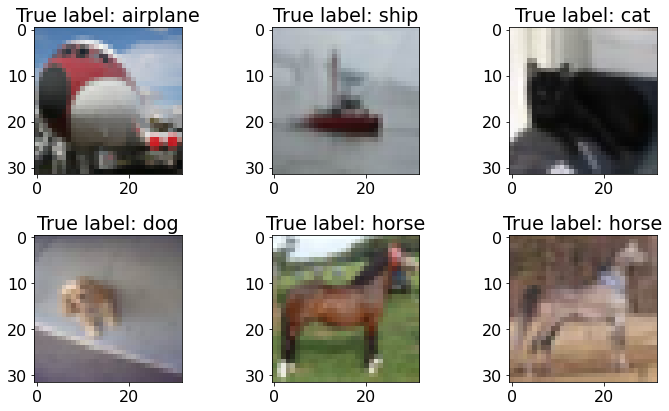

In [9]:
#-- Plot a few examples:
N, d   = mX.shape
fig, _ = plt.subplots(2, 3, figsize=(10,6))
for ax in fig.axes:
    idx = np.random.randint(0, N)
    ax.imshow(np.reshape(mX[idx,:], (32, 32, 3)))
    ax.set_title('True label: ' + str(lClasses[vY[idx]]))
    
plt.tight_layout()
plt.show()

###  Normalize data:

In [10]:
vMean = np.mean(mX, axis=0)
vStd  = np.std(mX, axis=0)
mX    = (mX - vMean) / vStd

###  Split to train and validation:

In [11]:
from sklearn.model_selection import train_test_split

Ntrain = 45000
Nval   = 5000
mTrainX, mValX, vTrainY, vValY = train_test_split(mX, vY, train_size=Ntrain, test_size=Nval)

batchSize     = 1024
oTrainSet     = Dataset(mTrainX.T, vTrainY, batchSize)
oValSet       = Dataset(mValX.T,   vValY,   2*batchSize)

(mTrainX.shape, 
vTrainY.shape, 
mValX.shape,  
vValY.shape)

((45000, 3072), (45000,), (5000, 3072), (5000,))

###  Define a model:

In [12]:
def GetModel():
    oModel = SequentialModel([
        LinearLayer(32*32*3, 200),
        ReLULayer(),
        LinearLayer(200, 100),
        ReLULayer(),
        LinearLayer(100, 50),
        ReLULayer(),
        LinearLayer(50, 10),
    ])
    
    return oModel

### Train without weight decay:

<IPython.core.display.Javascript object>


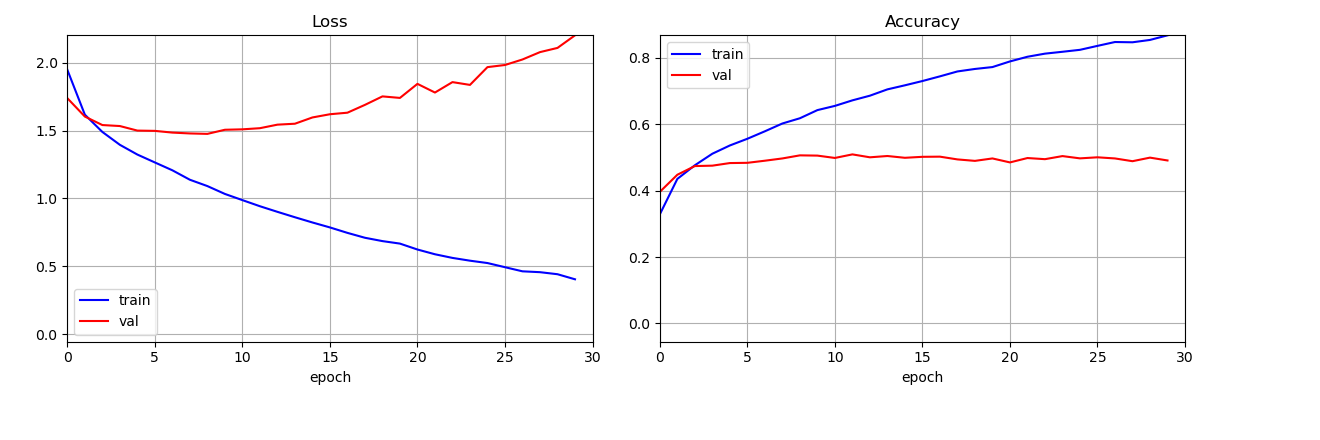

Epoch   0: | Train loss: 1.94701 | Val loss: 1.73803 | Train Accuracy: 0.3286 | Val Accuracy: 0.3962 | epoch time: 5.098 |
Epoch   1: | Train loss: 1.61667 | Val loss: 1.60285 | Train Accuracy: 0.4352 | Val Accuracy: 0.4478 | epoch time: 5.081 |
Epoch   2: | Train loss: 1.48959 | Val loss: 1.54029 | Train Accuracy: 0.4763 | Val Accuracy: 0.4739 | epoch time: 5.168 |
Epoch   3: | Train loss: 1.39480 | Val loss: 1.53297 | Train Accuracy: 0.5111 | Val Accuracy: 0.4751 | epoch time: 5.155 |
Epoch   4: | Train loss: 1.32302 | Val loss: 1.49944 | Train Accuracy: 0.5359 | Val Accuracy: 0.4829 | epoch time: 5.144 |
Epoch   5: | Train loss: 1.26488 | Val loss: 1.49742 | Train Accuracy: 0.5561 | Val Accuracy: 0.4836 | epoch time: 4.949 |
Epoch   6: | Train loss: 1.20709 | Val loss: 1.48467 | Train Accuracy: 0.5786 | Val Accuracy: 0.4900 | epoch time: 4.819 |
Epoch   7: | Train loss: 1.13757 | Val loss: 1.47847 | Train Accuracy: 0.6020 | Val Accuracy: 0.4968 | epoch time: 4.653 |
Epoch   8: | Tra

In [13]:
%matplotlib notebook

np.random.seed(1)
oModel = GetModel()
oOptim = Optimizer(AdamW(lr=1e-3, beta1=0.9, beta2=0.99, wd=0))
TrainModel(oModel, oTrainSet, oValSet, 30, oOptim)

### Train with weight decay:

<IPython.core.display.Javascript object>


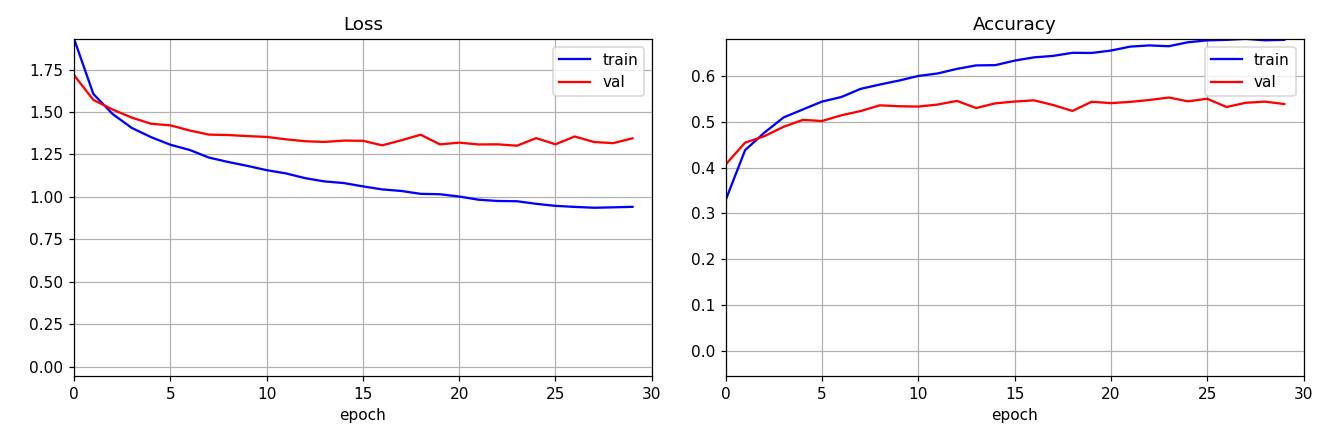

Epoch   0: | Train loss: 1.93085 | Val loss: 1.71683 | Train Accuracy: 0.3300 | Val Accuracy: 0.4072 | epoch time: 4.841 |
Epoch   1: | Train loss: 1.60648 | Val loss: 1.57147 | Train Accuracy: 0.4382 | Val Accuracy: 0.4546 | epoch time: 5.033 |
Epoch   2: | Train loss: 1.48812 | Val loss: 1.51441 | Train Accuracy: 0.4764 | Val Accuracy: 0.4688 | epoch time: 4.979 |
Epoch   3: | Train loss: 1.40584 | Val loss: 1.46666 | Train Accuracy: 0.5097 | Val Accuracy: 0.4893 | epoch time: 4.892 |
Epoch   4: | Train loss: 1.35165 | Val loss: 1.43058 | Train Accuracy: 0.5271 | Val Accuracy: 0.5044 | epoch time: 5.116 |
Epoch   5: | Train loss: 1.30701 | Val loss: 1.42144 | Train Accuracy: 0.5444 | Val Accuracy: 0.5020 | epoch time: 5.314 |
Epoch   6: | Train loss: 1.27649 | Val loss: 1.39103 | Train Accuracy: 0.5543 | Val Accuracy: 0.5144 | epoch time: 5.641 |
Epoch   7: | Train loss: 1.23144 | Val loss: 1.36677 | Train Accuracy: 0.5722 | Val Accuracy: 0.5237 | epoch time: 5.836 |
Epoch   8: | Tra

In [14]:
%matplotlib notebook

np.random.seed(1)
oModel = GetModel()
oOptim = Optimizer(AdamW(lr=1e-3, beta1=0.9, beta2=0.99, wd=2e-3))
TrainModel(oModel, oTrainSet, oValSet, 30, oOptim)

### Dropout layer:
Forwrad:
$$\boldsymbol{z}=\frac{1}{p}\boldsymbol{x}\odot\boldsymbol{m}=\frac{1}{p}\text{diag}\left(\boldsymbol{m}\right)\boldsymbol{x}$$
where $\boldsymbol{m}$ is a mask (same size as $\boldsymbol{x}$)
such that each $\boldsymbol{m}\left[i\right]\sim\text{Bernoulli}\left(p\right)$

Backward:
$$
\left\langle \nabla_{\boldsymbol{z}}L,\nabla_{\boldsymbol{x}}\boldsymbol{z}\left[\boldsymbol{h}\right]\right\rangle =\left\langle \nabla_{\boldsymbol{z}}L,\frac{1}{p}\text{diag}\left(\boldsymbol{m}\right)\boldsymbol{h}\right\rangle =\left\langle \frac{1}{p}\text{diag}\left(\boldsymbol{m}\right)\nabla_{\boldsymbol{z}}L,\boldsymbol{h}\right\rangle 
$$
$$
\implies\boxed{\nabla_{\boldsymbol{x}}L=\frac{1}{p}\text{diag}\left(\boldsymbol{m}\right)\nabla_{\boldsymbol{z}}L=\frac{1}{p}\nabla_{\boldsymbol{z}}L\odot\boldsymbol{m}}
$$


In [18]:
class DropoutLayer:
    def __init__(self, p=0.5):
        self.dGrads = {}
        self.p      = p

    #-- Train time:
    def Forward(self, mX):
        self.mMask = (np.random.rand(*mX.shape) < self.p).astype(float) / self.p
        mZ         = mX * self.mMask

        return mZ

    #-- Test time:
    def Predict(self, mX):
        return mX
    
    def Backward(self, mDz):
        mDx   = mDz * self.mMask

        return mDx

###  We need to track if we training or testing:

In [24]:
class SequentialModel:
    def __init__(self, lLayers):
        self.lLayers = lLayers
        self.train   = False

    def Forward(self, mX):
        for oLayer in self.lLayers:
            if self.train == False and hasattr(oLayer, 'Predict'):
                #-- Test time:
                mX = oLayer.Predict(mX)
            else:
                #-- Train time:
                mX = oLayer.Forward(mX)
        return mX

    def Backward(self, mDz):
        for oLayer in reversed(self.lLayers):
            mDz = oLayer.Backward(mDz)

In [25]:
import time

def TrainLoop(oModel, oTrainData, oOptim):

    epochLoss    = 0
    epochAcc     = 0
    oModel.train = True
    #-- Iterate over the mini-batches:
    for ii, (mX, vY) in enumerate(oTrainData):
        #-- Forward:
        mZ        = oModel.Forward(mX)
        loss, mDz = CrossEntropyLoss(vY, mZ)

        #-- Backward:
        oModel.Backward(mDz)

        #-- Update parameters
        oOptim.Step(oModel)

        epochLoss += loss
        epochAcc  += Accuracy(mZ, vY)
        print(f'Iteration: {ii:3d}: loss = {loss:.6f}\r', end='')

    epochLoss /= ii + 1
    epochAcc  /= ii + 1

    return epochLoss, epochAcc

#--------------------------------------------------------------------------------#
#--------------------------------------------------------------------------------#
def ValidationLoop(oModel, oValData):

    epochLoss = 0
    epochAcc  = 0
    #-- Iterate over the mini-batches:
    oModel.train = False
    for ii, (mX, vY) in enumerate(oValData):
        #-- Forward:
        mZ      = oModel.Forward(mX)
        loss, _ = CrossEntropyLoss(vY, mZ)

        epochLoss += loss
        epochAcc  += Accuracy(mZ, vY)

    epochLoss /= ii + 1
    epochAcc  /= ii + 1

    return epochLoss, epochAcc

#--------------------------------------------------------------------------------#
#--------------------------------------------------------------------------------#
def TrainModel(oModel, oTrainData, oValData, numEpochs, oOptim):

    oRecorder = Recorder([
        Plot('Loss',       'train', 'epoch', 'b'),
        Plot('Loss',       'val',   'epoch', 'r'),
        Plot('Accuracy',   'train', 'epoch', 'b'),
        Plot('Accuracy',   'val',   'epoch', 'r'),
    ])

    for epoch in range(numEpochs):
        startTime           = time.time()
        #-- Train:
        trainLoss, trainAcc = TrainLoop(oModel, oTrainData, oOptim)
        #-- Validation:
        valLoss,   valAcc   = ValidationLoop(oModel, oValData)
        endTime             = time.time()

        #-- Display:
        oRecorder.Append('Loss',     'train', trainLoss),
        oRecorder.Append('Loss',     'val',   valLoss),
        oRecorder.Append('Accuracy', 'train', trainAcc),
        oRecorder.Append('Accuracy', 'val',   valAcc),
        oRecorder.Draw()

        print('Epoch '              f'{epoch:3d}:',     end='')
        print(' | Train loss: '     f'{trainLoss:.5f}', end='')
        print(' | Val loss: '       f'{valLoss:.5f}',   end='')
        print(' | Train Accuracy: ' f'{trainAcc:2.4f}', end='')
        print(' | Val Accuracy: '   f'{valAcc:2.4f}',   end='')
        print(' | epoch time: '     f'{(endTime-startTime):3.3f} |')


### Define the same architecture but with dropouts:

In [26]:
def GetModelWithDropout():
    oModel = SequentialModel([
        LinearLayer(32*32*3, 200),
        ReLULayer(),
        DropoutLayer(p=4/5),
        LinearLayer(200, 100),
        ReLULayer(),
        DropoutLayer(p=4/5),
        LinearLayer(100, 50),
        ReLULayer(),
        DropoutLayer(p=9/10),
        LinearLayer(50, 10),
    ])
    
    return oModel

<IPython.core.display.Javascript object>


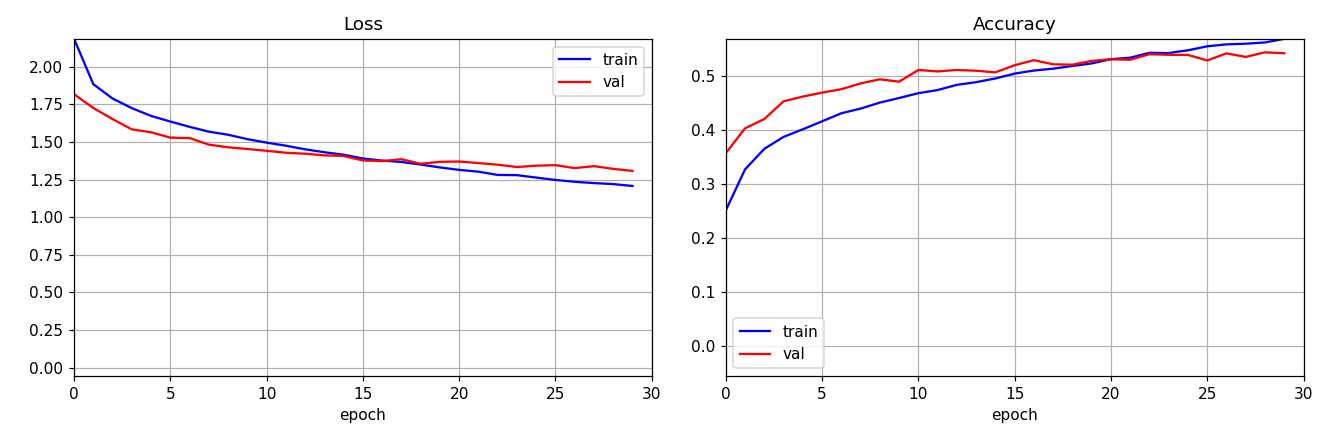

Epoch   0: | Train loss: 2.18630 | Val loss: 1.81835 | Train Accuracy: 0.2518 | Val Accuracy: 0.3579 | epoch time: 5.226 |
Epoch   1: | Train loss: 1.88478 | Val loss: 1.72632 | Train Accuracy: 0.3278 | Val Accuracy: 0.4038 | epoch time: 5.263 |
Epoch   2: | Train loss: 1.78947 | Val loss: 1.65255 | Train Accuracy: 0.3658 | Val Accuracy: 0.4211 | epoch time: 4.976 |
Epoch   3: | Train loss: 1.72544 | Val loss: 1.58439 | Train Accuracy: 0.3879 | Val Accuracy: 0.4539 | epoch time: 5.070 |
Epoch   4: | Train loss: 1.67375 | Val loss: 1.56517 | Train Accuracy: 0.4020 | Val Accuracy: 0.4626 | epoch time: 5.170 |
Epoch   5: | Train loss: 1.63648 | Val loss: 1.52921 | Train Accuracy: 0.4168 | Val Accuracy: 0.4700 | epoch time: 5.133 |
Epoch   6: | Train loss: 1.60106 | Val loss: 1.52668 | Train Accuracy: 0.4317 | Val Accuracy: 0.4763 | epoch time: 5.147 |
Epoch   7: | Train loss: 1.56921 | Val loss: 1.48295 | Train Accuracy: 0.4404 | Val Accuracy: 0.4871 | epoch time: 5.140 |
Epoch   8: | Tra

In [22]:
%matplotlib notebook

np.random.seed(1)
oModel = GetModelWithDropout()
oOptim = Optimizer(AdamW(lr=1e-3, beta1=0.9, beta2=0.99, wd=0))
TrainModel(oModel, oTrainSet, oValSet, 30, oOptim)

### Dropout + weight decay:

<IPython.core.display.Javascript object>


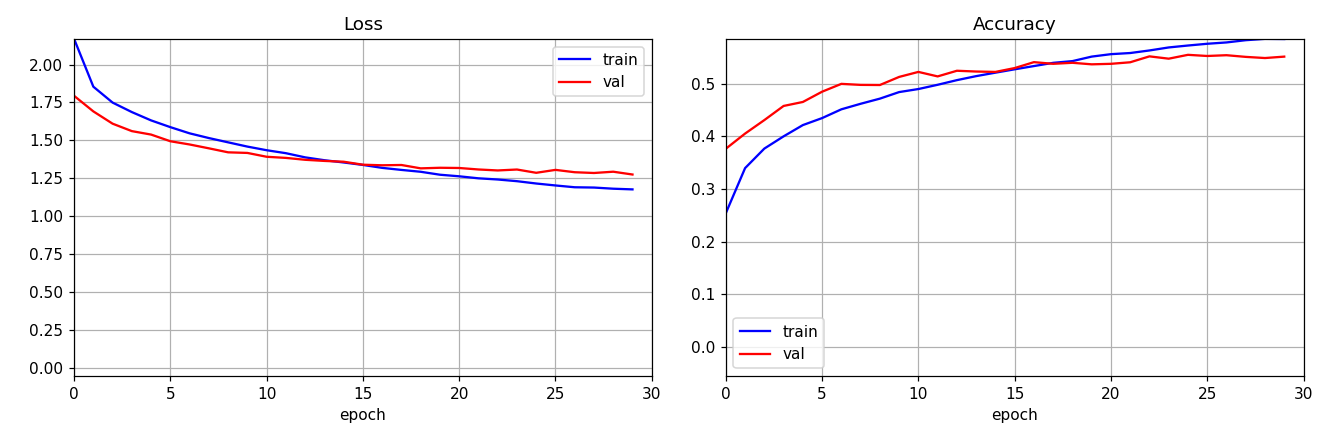

Epoch   0: | Train loss: 2.16998 | Val loss: 1.79402 | Train Accuracy: 0.2543 | Val Accuracy: 0.3767 | epoch time: 5.288 |
Epoch   1: | Train loss: 1.85431 | Val loss: 1.69119 | Train Accuracy: 0.3399 | Val Accuracy: 0.4055 | epoch time: 4.927 |
Epoch   2: | Train loss: 1.74931 | Val loss: 1.61010 | Train Accuracy: 0.3770 | Val Accuracy: 0.4312 | epoch time: 4.982 |
Epoch   3: | Train loss: 1.68664 | Val loss: 1.56094 | Train Accuracy: 0.4003 | Val Accuracy: 0.4580 | epoch time: 5.020 |
Epoch   4: | Train loss: 1.63166 | Val loss: 1.53811 | Train Accuracy: 0.4216 | Val Accuracy: 0.4656 | epoch time: 5.104 |
Epoch   5: | Train loss: 1.58717 | Val loss: 1.49403 | Train Accuracy: 0.4350 | Val Accuracy: 0.4851 | epoch time: 5.253 |
Epoch   6: | Train loss: 1.54628 | Val loss: 1.47278 | Train Accuracy: 0.4516 | Val Accuracy: 0.5000 | epoch time: 5.220 |
Epoch   7: | Train loss: 1.51514 | Val loss: 1.44733 | Train Accuracy: 0.4621 | Val Accuracy: 0.4980 | epoch time: 4.982 |
Epoch   8: | Tra

In [23]:
%matplotlib notebook

np.random.seed(1)
oModel = GetModelWithDropout()
oOptim = Optimizer(AdamW(lr=1e-3, beta1=0.9, beta2=0.99, wd=1e-3))
TrainModel(oModel, oTrainSet, oValSet, 30, oOptim)